In [21]:
# Imports
import numpy as np
import cv2
import copy
from sklearn import mixture
from tqdm import tqdm
from igraph import Graph
import matplotlib.pyplot as plt
# import grabCut

#import warnings
#warnings.warn(" ")
#import jgapht

## Energy function and grabcut algorithm

In [22]:
import numpy as np
import cv2
import igraph as ig
from sklearn.mixture import GaussianMixture
from random import randint
# Class that defines the grabcut algorithm
class grabCut:
    def __init__(self,boundBox = [0, 0, 0, 0]):
        self.background = 0 
        self.foreground = 1 
        self.source = 0
        self.tank = 0
        self.toBeForegroundPix = 3 
        self.tobeBackgroundPix = 2 
        self.gamma = 50 # Suggested in the paper
        self.image = 0
        self.lVal = 0
        self.uVal = 0
        self.uLVal = 0
        self.uRVal = 0
        self.indexCalc = 0
        self.indexesFg = 0
        self.indexesBg = 0
        self.iterCount = 3
        self.Kgmms = 5
        self.tmp = False
        self.tmp1 = False
        self.rows = 0
        self.cols = 0
#     High level grabcut function
    def algo(self,img, mask, bbox, Kgmms=5, iterCounts=3):

        self.rows, self.cols = img[:, :, 2].shape
        self.source = self.cols * self.rows
        self.image = img.astype(np.float64)
        self.indexCalc = np.zeros((self.rows, self.cols), dtype=np.uint32)
        self.tank = self.source + 1
        self.iterCounts = iterCounts
        mask[bbox[1]:bbox[1] + bbox[3], bbox[0]:bbox[0] + bbox[2]] = self.toBeForegroundPix
        self.Kgmms = Kgmms
        self.indexesBg = np.where(np.logical_or(mask == self.background, mask == self.tobeBackgroundPix))
        self.indexesFg = np.where(np.logical_or(mask == self.foreground, mask == self.toBeForegroundPix))
        self.lVal = np.zeros((self.rows, self.cols - 1))
        self.uVal = np.zeros((self.rows - 1, self.cols))
        self.uLVal = np.zeros((self.rows - 1, self.cols - 1)) 
        self.uRVal = np.zeros((self.rows - 1, self.cols - 1))    

        backgroud_gmm = GaussianMixture(n_components = self.Kgmms)
        foregroud_gmm = GaussianMixture(n_components = self.Kgmms)

        mask = self.weightsCap(backgroud_gmm, foregroud_gmm, mask)

        return np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        
# Defining the Source-sink graph function
    def stGraphFun(self, backgroud_gmm, foregroud_gmm, mask):

        edges, capacity = [], []

        # t-links

        indexLik = np.where(np.logical_or(mask.reshape(-1) == self.tobeBackgroundPix, mask.reshape(-1) == self.toBeForegroundPix))

        edges.extend(list(zip([self.source] * indexLik[0].size, indexLik[0])))
        D = backgroud_gmm.score_samples(self.image.reshape(-1, 3)[indexLik])
        D = -D
        capacity.extend(D.tolist())

        edges.extend(list(zip([self.tank] * indexLik[0].size, indexLik[0])))
        D = foregroud_gmm.score_samples(self.image.reshape(-1, 3)[indexLik])
        D = -D
        capacity.extend(D.tolist())


        edges.extend(list(zip([self.source] * self.indexesBg[0].size, self.indexesBg[0])))
        edges.extend(list(zip([self.tank] * self.indexesBg[0].size, self.indexesBg[0])))

        capacity.extend([0] * self.indexesBg[0].size)
        capacity.extend([9 * self.gamma] * self.indexesBg[0].size)

        edges.extend(list(zip([self.source] * self.indexesFg[0].size, self.indexesFg[0])))
        edges.extend(list(zip([self.tank] * self.indexesFg[0].size, self.indexesFg[0])))

        capacity.extend([9 * self.gamma] * self.indexesFg[0].size)
        capacity.extend([0] * self.indexesFg[0].size)

        # n-links
        img_indexes = np.arange(self.rows * self.cols, dtype=np.uint32).reshape(self.rows, self.cols)

        capacity.extend(self.lVal.reshape(-1).tolist())
        capacity.extend(self.uVal.reshape(-1).tolist())
        capacity.extend(self.uLVal.reshape(-1).tolist())
        capacity.extend(self.uRVal.reshape(-1).tolist())

        edges.extend(list(zip(img_indexes[:, 1:].reshape(-1), img_indexes[:, :-1].reshape(-1))))
        edges.extend(list(zip(img_indexes[1:, :].reshape(-1), img_indexes[:-1, :].reshape(-1))))
        edges.extend(list(zip(img_indexes[1:, 1:].reshape(-1), img_indexes[:-1, :-1].reshape(-1))))
        edges.extend(list(zip(img_indexes[1:, :-1].reshape(-1), img_indexes[:-1, 1:].reshape(-1))))


        graph = ig.Graph(2 + self.cols * self.rows)
        graph.add_edges(edges)

        return graph, capacity
# Function to assign the weights of to the graph. And the gmm components
    def weightsCap(self, backgroud_gmm, foregroud_gmm, mask):
        for num in range(self.iterCounts):    
            backgroud_gmm.fit(self.image[self.indexesBg])
            foregroud_gmm.fit(self.image[self.indexesFg])
            self.indexCalc[self.indexesBg] = backgroud_gmm.predict(self.image[self.indexesBg])
            self.indexCalc[self.indexesFg] = foregroud_gmm.predict(self.image[self.indexesFg])
            backgroud_gmm.fit(self.image[self.indexesBg], self.indexCalc[self.indexesBg])
            foregroud_gmm.fit(self.image[self.indexesFg], self.indexCalc[self.indexesFg])
            graph, capacity = self.stGraphFun(backgroud_gmm,foregroud_gmm, mask)
            img_indexes = np.arange(self.rows * self.cols, dtype=np.uint32).reshape(self.rows, self.cols)
            indexLik = np.where(np.logical_or(mask == self.tobeBackgroundPix, mask == self.toBeForegroundPix))
            mincut = graph.st_mincut(self.source, self.tank, capacity)
            mask[indexLik] = np.where(np.isin(img_indexes[indexLik], mincut.partition[0]),self.toBeForegroundPix, self.tobeBackgroundPix)
            print("done Iteration Number :",num)
        return mask


## Interface function

In [23]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors
       

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)
               
                

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [24]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
        
    }

    img = cv2.imread(filename)
    img2 = img.copy()                                
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
#             mask=np.zeros((img2[:2]),dtype=np.uint8)
#             mask=np.where()
#             mask2 = np.where((mask == 1), 255, 0).astype('uint8')
        
            
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
            print('FLAGS[VALUE] foreground',FLAGS['value'])
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            
            EventObj.flags = FLAGS
            h,w=np.array(img).shape[0],np.array(img).shape[1]
#             print(FLAGS['RECT'])
            v1,v2,v3,v4=FLAGS['RECT']
#             print(h,w)
#             print(v1,v3)
            gCt=grabCut()
            bbox=FLAGS['RECT']
            EventObj.mask = gCt.algo(img, EventObj.mask, bbox, iterCounts = 3, Kgmms=5)
#             print("bbox output=",np.where(EventObj.mask==2))
            imgc = img.copy()
            out = cv2.bitwise_and(imgc, imgc, mask=EventObj.mask)
#             print("maks inside=",EventObj.mask)
            output=out
            plt.imshow(cv2.cvtColor(output,cv2.COLOR_BGR2RGB))
            plt.title("Segmented Image")
#             print("iters: ", 1, "num_comps: ", 3)
#             plt.subplot(1, 2, 2)
#             plt.axis('off')
#             plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
#             plt.title("Output")
# #             return mask2,img2

        
    

            
        

done Iteration Number : 0
done Iteration Number : 1
done Iteration Number : 2


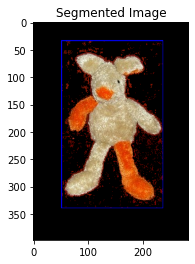

In [25]:
if __name__ == '__main__':
    filename = '../images/teddy.jpg'               # Path to image file
    run(filename)
    
#     print(mask)
#     plt.imshow(img2)
    cv2.destroyAllWindows()

done Iteration Number : 0
done Iteration Number : 1
done Iteration Number : 2


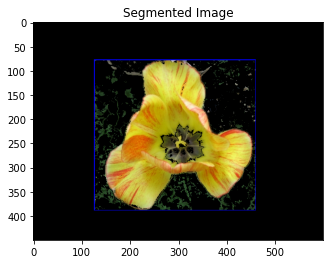

In [26]:
if __name__ == '__main__':
    filename = '../images/flower.jpg'               # Path to image file
    run(filename)
    
#     print(mask)
#     plt.imshow(img2)
    cv2.destroyAllWindows()

done Iteration Number : 0
done Iteration Number : 1
done Iteration Number : 2


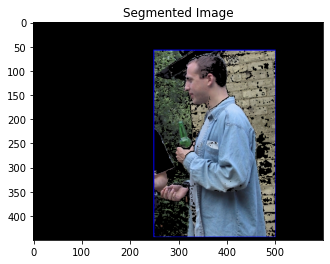

In [27]:
if __name__ == '__main__':
    filename = '../images/person4.jpg'               # Path to image file
    run(filename)
    
#     print(mask)
#     plt.imshow(img2)
    cv2.destroyAllWindows()

done Iteration Number : 0
done Iteration Number : 1
done Iteration Number : 2


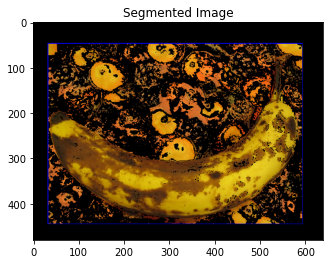

In [28]:
if __name__ == '__main__':
    filename = '../images/banana2.jpg'               # Path to image file
    run(filename)
    
#     print(mask)
#     plt.imshow(img2)
    cv2.destroyAllWindows()

done Iteration Number : 0
done Iteration Number : 1
done Iteration Number : 2


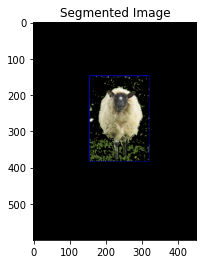

In [29]:
if __name__ == '__main__':
    filename = '../images/sheep.jpg'               # Path to image file
    run(filename)
    
#     print(mask)
#     plt.imshow(img2)
    cv2.destroyAllWindows()